In [13]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import random
import sys
import json
import pandas as pd
sys.path.append('src/recommendation')
import matchings

from Dataset import Dataset
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import DQN, A2C, PPO, SAC, TD3, DDPG

from stable_baselines3.common.callbacks import BaseCallback

from CourseRecEnv import CourseRecEnv, EvaluateCallback

%load_ext autoreload
%autoreload 2

In [3]:
import os
import json
results_path = "data/V2/old_results/"
model = "greedy_nbskills_46"
table = ""
for model in ["greedy_nbskills_46", "optimal_nbskills_46", "final_dqn_nbskills_46", "final_a2c_nbskills_46", "final_ppo_nbskills_46"]:
    for k in [1,2,3,4,5]:
        for file in os.listdir(results_path):
            if ("k_" + str(k)) in file and file.startswith(model):
                filepath = os.path.join(results_path, file)
                print(filepath)
                results = json.load(open(filepath))
                table += f'{ results["new_applicable_jobs"]:.4} & '
                table += f'{1000*results["avg_recommendation_time"]:.2} &'
    table=table[:-1]
    table+= f'\\\\\n'
print(table)

data/V2/old_results/greedy_nbskills_46_k_1_run_0.json
data/V2/old_results/greedy_nbskills_46_k_2_run_0.json
data/V2/old_results/greedy_nbskills_46_k_3_run_0.json
data/V2/old_results/greedy_nbskills_46_k_4_run_0.json
data/V2/old_results/greedy_nbskills_46_k_5_run_0.json
data/V2/old_results/optimal_nbskills_46_k_1_run_0.json
data/V2/old_results/optimal_nbskills_46_k_2_run_0.json
data/V2/old_results/optimal_nbskills_46_k_3_run_0.json
data/V2/old_results/final_dqn_nbskills_46_k_1_run_0.json
data/V2/old_results/final_dqn_nbskills_46_k_2_run_0.json
data/V2/old_results/final_dqn_nbskills_46_k_3_run_0.json
data/V2/old_results/final_a2c_nbskills_46_k_1_run_0.json
data/V2/old_results/final_a2c_nbskills_46_k_2_run_0.json
data/V2/old_results/final_a2c_nbskills_46_k_3_run_0.json
data/V2/old_results/final_ppo_nbskills_46_k_1_run_0.json
data/V2/old_results/final_ppo_nbskills_46_k_2_run_0.json
data/V2/old_results/final_ppo_nbskills_46_k_3_run_0.json
0.9808 & 1.6e+01 &1.981 & 4.1e+01 &4.135 & 7.3e+01 &

In [2]:
dataset_short = Dataset("config/dataset_V2.yaml")
print(dataset_short)

Dataset with 52 learners, 100 jobs, 100 courses and 46 skills.


In [7]:
dataset_all = Dataset("config/dataset_V2_all.yaml")
print(dataset_all)

Dataset with 49 learners, 500 jobs, 495 courses and 1794 skills.


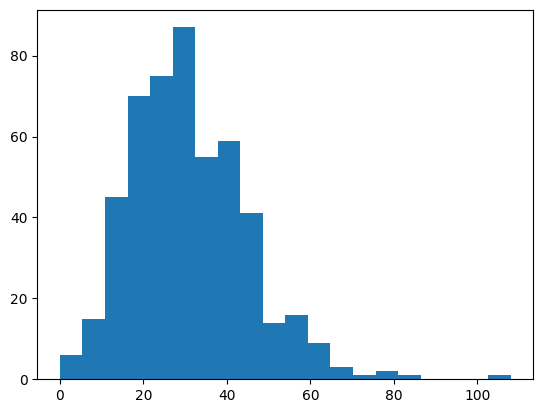

Average and std number of skills for jobs in dataset.jobs:  30.862 14.078030970274217


In [8]:
# plot the histogram of number of skills for jobs in dataset.jobs
import matplotlib.pyplot as plt
job_skill_list = [len(job) for job in dataset_all.jobs]
plt.hist(job_skill_list, bins=20)
plt.show()
print("Average and std number of skills for jobs in dataset.jobs: ", np.mean(job_skill_list), np.std(job_skill_list))

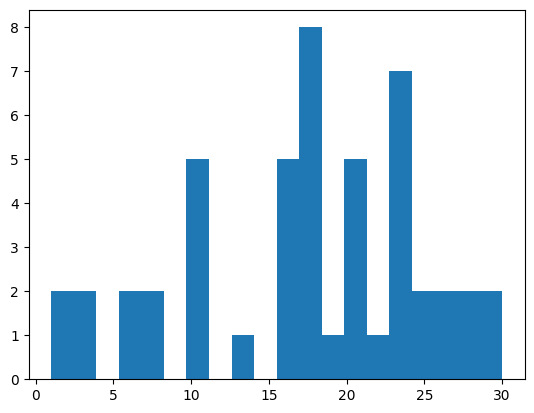

Average and std number of skills for learners in dataset.learners:  17.346938775510203 7.482090236182267


In [9]:
learner_skill_list = [len(learner) for learner in dataset_all.learners]
plt.hist(learner_skill_list, bins=20)
plt.show()
print("Average and std number of skills for learners in dataset.learners: ", np.mean(learner_skill_list), np.std(learner_skill_list))

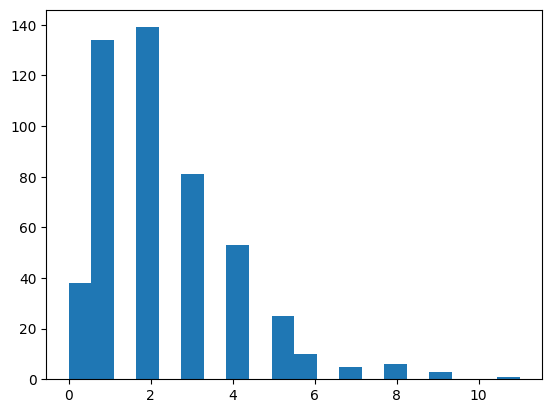

In [10]:
# plot the histogram of number of skills for jobs in dataset.jobs
import matplotlib.pyplot as plt
plt.hist([len(course[0]) for course in dataset_all.courses], bins=20)
plt.show()

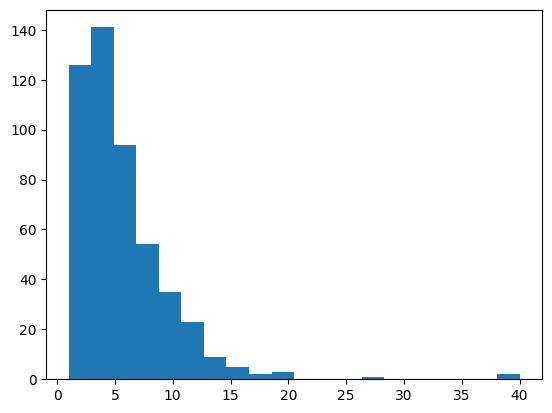

In [11]:
# plot the histogram of number of skills for jobs in dataset.jobs
import matplotlib.pyplot as plt
plt.hist([len(course[1]) for course in dataset_all.courses], bins=20)
plt.show()

In [63]:
backslash = '\\'
def mystery(a,n,j,x):
    if j==0:
        print(f"{backslash}hphantom{{ }}{backslash}hspace{{{(2-j)}cm}}Returning {x}\\\\")
        return x
    else:
        print(f"{backslash}hphantom{{ }}{backslash}hspace{{{(2-j)}cm}}For j={j} x={x}, and i={1} calling mystery(a,n,{j-1},{x}*{a[0]})\\\\")
        c = mystery(a,n,j-1,x*a[0])
        for i in range(1,n):
            print(f"{backslash}hphantom{{ }}{backslash}hspace{{{(2-j)}cm}}For j={j}, x={x}, and i={i+1} calling mystery(a,n,{j-1},{x}*{a[1]})\\\\")
            d = mystery(a,n,j-1,x*a[i])
            print(f"{backslash}hphantom{{ }}{backslash}hspace{{{(2-j)}cm}}Calling max({c},{d})\\\\")
            if d > c:
                c = d
        print(f"{backslash}hphantom{{ }}{backslash}hspace{{{(2-j)}cm}}Returning {c}\\\\")
        return c

In [64]:
mystery([-5,4],2,2,1)

\hphantom{ }\hspace{0cm}For j=2 x=1, and i=1 calling mystery(a,n,1,1*-5)\\
\hphantom{ }\hspace{1cm}For j=1 x=-5, and i=1 calling mystery(a,n,0,-5*-5)\\
\hphantom{ }\hspace{2cm}Returning 25\\
\hphantom{ }\hspace{1cm}For j=1, x=-5, and i=2 calling mystery(a,n,0,-5*4)\\
\hphantom{ }\hspace{2cm}Returning -20\\
\hphantom{ }\hspace{1cm}Calling max(25,-20)\\
\hphantom{ }\hspace{1cm}Returning 25\\
\hphantom{ }\hspace{0cm}For j=2, x=1, and i=2 calling mystery(a,n,1,1*4)\\
\hphantom{ }\hspace{1cm}For j=1 x=4, and i=1 calling mystery(a,n,0,4*-5)\\
\hphantom{ }\hspace{2cm}Returning -20\\
\hphantom{ }\hspace{1cm}For j=1, x=4, and i=2 calling mystery(a,n,0,4*4)\\
\hphantom{ }\hspace{2cm}Returning 16\\
\hphantom{ }\hspace{1cm}Calling max(-20,16)\\
\hphantom{ }\hspace{1cm}Returning 16\\
\hphantom{ }\hspace{0cm}Calling max(25,16)\\
\hphantom{ }\hspace{0cm}Returning 25\\


25

In [16]:
# generates all binary strings of length n usong itertoolls.product
import itertools
a = []
for n in range(1, 10):
    nb_valid_strings = 0
    for elem in itertools.product(['0', '1'], repeat=n):
        seq = ''.join(list(elem))
        if '00' in seq and '11' in seq:
            nb_valid_strings += 1
    rec=0
    if n>3:
        rec = 2*a[-1] + 2**(n-3) -a[-3]
    a.append(nb_valid_strings)
    print(n, nb_valid_strings, rec)


1 0 0
2 0 0
3 0 0
4 2 2
5 8 8
6 24 24
7 62 62
8 148 148
9 336 336
